Notebook Logistic Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Logistic Regression toepassen op de data voor classificatie
- andere vormen van classificatie toepassen zonder en met hyper parameter tuning

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- missing data oplossen 
- incorrect types controleren
- numerische waarde standardizeren
- categorische varaiabelen processen
- feature engineering
- select features for modelling
- eenvoudige logistic regression
- eenvoudige logistic regression en unbalance van de features corrigeren met SMOTE- en class_weight = 'unbalanced
- functie voor modeling met Logistic Regression, Decision Tree Regression en Random Forrest Regression, met uitvoering
- functie modeling met Hyperparameter tuning met GridSearchCV voor drie modellen, met uitvoering


Bij run ALL: (duurt 20 min)
- output in LogReg_continue.log
- de plots worden bewaard in de images\


Aantal testen werdern uitgevoerd, met en zonder SMOTE, met en zonder HyperParameter tuning maar de resultaten veranderen niet zo veel
Ook logistic regression met class_weight='balanced' maar op zich weinig verschil in de resultaten

De functies zijn geschreven. We kunnen nadien nog extra testen doen met bepaalde features wel of niet mee te nemen



In [1]:
# import van de diverse modules
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from collections import Counter
from sklearn.base import TransformerMixin, BaseEstimator
from imblearn.under_sampling import RandomUnderSampler

# Machine learning algorithm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# system utils
import warnings
from pathlib import Path
import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet
from summarytools import dfSummary
from tabulate import tabulate


plot_graphs = True

Extra code snippits die doorheen de notebook gebruikt worden:

save_fig: na generatie van een image kan de image naar file geschreven worden in de images/.. directory. Geef steeds een zinvolle naam

read_JSON: om eenvoudig een JSON in te lezen

log_info:
- logging functie om doorheen de notebooks de status naar file te kunnen schrijven. 
- de logstatements worden tijdens de uitvoering van de code bewaard in een list. Die kan tussentijds naar het scherm geprint worden of naar een file
- log_info_write_to_file: schrijf de loginformatie naar file 
- log_info_print_on_screen: print alle loginfo naar het scherm

In [2]:
# enkele extra code snippets gebruikt doorheen de oefening

# to plot or not to plot - zet op True om de plots te zien, zet op False om de plots niet te zien bij een Run ALL
plot_graphs = True


# schrijf een visual naar file

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Lezen van de JSON-file
def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json

# functies om te loggen naar file
log_info_lijst = []

log_filenaam = "LogReg_continue.log"
if os.path.exists(log_filenaam):
    os.remove(log_filenaam)

def log(log_code="INFO", boodschap="euh geen boodschap????"):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : {log_code} : {boodschap}"
    log_info_lijst.append(log_message)
    with open(log_filenaam, 'a') as file:  # Open the file in append mode
        file.write(boodschap + '\n')  # Voeg een nieuwe regel toe na elke string
    print(log_message)
    return

def log_info(boodschap):
    log("Info",boodschap)
    def log_info_write_to_file(filename):
        with open(filename, 'a') as file:  # Open the file in append mode
            for string in log_info_lijst:
                file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
        return

def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return

def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return

In [3]:
def plot_histogram(dataframe, column, bins=20, color='blue', title='', xlabel='', ylabel='Frequentie', filenaam = "Histogram"):
    """
    Deze functie plot een histogram van een gespecificeerde kolom uit een pandas DataFrame.
    
    Parameters:
        dataframe (pd.DataFrame): Het DataFrame dat de data bevat.
        column (str): De naam van de kolom waarvan een histogram moet worden geplot.
        bins (int): Het aantal bins (groepen) voor het histogram.
        color (str): De kleur van de histogram bars.
        title (str): De titel van de plot.
        xlabel (str): De label voor de x-as.
        ylabel (str): De label voor de y-as.
    """
    # Controleer of de kolom bestaat in het DataFrame
    if column not in dataframe.columns:
        print(f"Kolom '{column}' niet gevonden in het DataFrame.")
        return

    # Plot het histogram
    plt.hist(dataframe[column], bins=bins, color=color, alpha=0.7)
    plt.title(title if title else f'Histogram van {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    if plot_graphs:
        save_fig(filenaam)
        plt.show()

Hulpfuncties

bereken_percentage_outliers: via Isolation forest wordt het percentage van de outliers berekend.
- df : dataframe
- columns_to_use: list van koloms die gebruikt worden om de outliers te berekenen
- functie geeft een percentage terug van het aaantal outliers op het totaal aantal observaties


cap_values: vervang outliers door hun lower of upperpercentieel waarde: de whiskers worden berekend door van de lower_percentieel waarde een waarde af te trekken gelijk aan 1,5 * IQR (interquartile range), voor upper_percentieel waarde wordt de 1,5 * IQR bijgeteld
- df: dataframe
- columns_to_use
- lower_percentieel (default = 25)
- upper_percentieel (default = 75)


In [4]:
# functie om het percentage outliers te berkenen voor een set van kolommen in een dataframe
def bereken_percentage_aantal_outliers(df , columns_to_use):
    # Initialiseren van het Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

    # Fit het model
    iso_forest.fit(df[columns_to_use])
    # Voorspellingen
    # Het geeft -1 voor outliers en 1 voor inliers
    labels = iso_forest.predict(df[columns_to_use])
    # Toevoegen van de labels aan het DataFrame om outliers te identificeren
    df_intern = df.copy()
    df_intern['outlier'] = labels
    outliers = df_intern[df_intern['outlier'] == -1]
    aantal_outliers = df_intern['outlier'].value_counts()
    print(aantal_outliers)
    percentage_aantal_outliers = (len(outliers) / len(df_intern)) * 100

    return percentage_aantal_outliers


# functie om outliers in een kolom te cappen op een percentiel waarde
def cap_values(df_input, column, lower_percentile=25, upper_percentile=75):
    # voeg code toe om beter de outliers te verwijderen
    log("Info", f"Capping values voor kolom {column} naar lower percentiel {lower_percentile} - upper percentiel {upper_percentile}")
    q1, q3 = np.percentile(df_input[column], [lower_percentile, upper_percentile])  # Calculate the 25th (Q1) and 75th (Q3) percentiles
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower whisker (Q1 - 1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr  # Calculate upper whisker (Q3 + 1.5 * IQR)

    # lower_bound = df[column].quantile(lower_percentile)
    # upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df_output = df_input.copy()
    df_output[column] = np.where(df_input[column] < lower_bound, lower_bound, df_input[column])
    df_output[column] = np.where(df_input[column] > upper_bound, upper_bound, df_input[column])    
    return df_output


In [5]:
# data inlezen van de file
heart_attack_risk_dataset_filename = 'data/heart_attack_risk_dataset.csv'
df = pd.read_csv(heart_attack_risk_dataset_filename)
log_info(f"File ingelezen: {heart_attack_risk_dataset_filename}")
df_raw = df.copy() # hou het ruwe dataframe bij

# lijst met features opgedeeld in numerisch en categorisch
df_col = df.columns
print(df_col)

# bepaal eerst de opdeling van numerische en categorische waarden op basis van de kolommen
# 3 opties

# optie 1: op basis van het datatype in de kolome
# df_num_col = df.select_dtypes(include='number').columns
# df_cat_col = df.select_dtypes(include='object').columns


# optie 2: op basis van de voorkomens van de waarden, indien <=4 is het een categorische 
# minder goed
# df_cat_col = [i for i in df.columns if df[i].nunique() <= 4]
# df_num_col= [i for i in df.columns if i not in df_cat_col]

# optie 3: en dit is de manuele manier om de lijst van kolommen voor numerische en categorische waarden samen te stellen
# check in via info() en describe() 
# we gaan dit verder gebruiken
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))
df_label_col = ['Heart_Attack_Risk'] # dit is de te voorspellen waarde
df_cat_nom_col = ['Gender', 'Physical_Activity_Level', 'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'ECG_Results', 'Heart_Attack_Risk']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]

16/02/2025 11:31:26 : Info : File ingelezen: data/heart_attack_risk_dataset.csv
Index(['Age', 'Gender', 'Smoking', 'Alcohol_Consumption',
       'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension',
       'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History',
       'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar',
       'ECG_Results', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved',
       'Heart_Attack_Risk'],
      dtype='object')


In [6]:
# eerste controles van alle waarden: 
# zijn er nulwaarden?
# zitten er geen duplicates tussen?

df.head()

# Maak een samenvatting 
df_summary = df.describe().transpose()
# Zet DataFrame om naar een mooie teksttabel
summary_str = tabulate(df_summary, headers='keys', tablefmt='psql')
# Print de string
log_info(f"\nDescribe van de dataset")
log_info(summary_str)

# check op nulwaarden:
aantal_nul_waarden = df.isnull().sum()
log_info(f"\nCheck op nulwaarden: \n{aantal_nul_waarden}")
# ok, geen nulwaarden

aantal_duplicated_waarden = df.duplicated().sum()
log_info(f"\nCheck op duplicates: \n{aantal_duplicated_waarden}")
# ok, geen duplicates

16/02/2025 11:31:26 : Info : 
Describe van de dataset
16/02/2025 11:31:26 : Info : +-------------------------+---------+-----------+-----------+-------+--------+--------+--------+-------+
|                         |   count |      mean |       std |   min |    25% |    50% |    75% |   max |
|-------------------------+---------+-----------+-----------+-------+--------+--------+--------+-------|
| Age                     |   50000 |  53.3987  | 20.799    |    18 |  35    |  53    |  71    |    89 |
| Smoking                 |   50000 |   0.29842 |  0.457569 |     0 |   0    |   0    |   1    |     1 |
| Alcohol_Consumption     |   50000 |   0.40198 |  0.490303 |     0 |   0    |   0    |   1    |     1 |
| BMI                     |   50000 |  27.5194  |  7.22518  |    15 |  21.27 |  27.54 |  33.77 |    40 |
| Diabetes                |   50000 |   0.19884 |  0.399131 |     0 |   0    |   0    |   0    |     1 |
| Hypertension            |   50000 |   0.29738 |  0.45711  |     0 |   0    

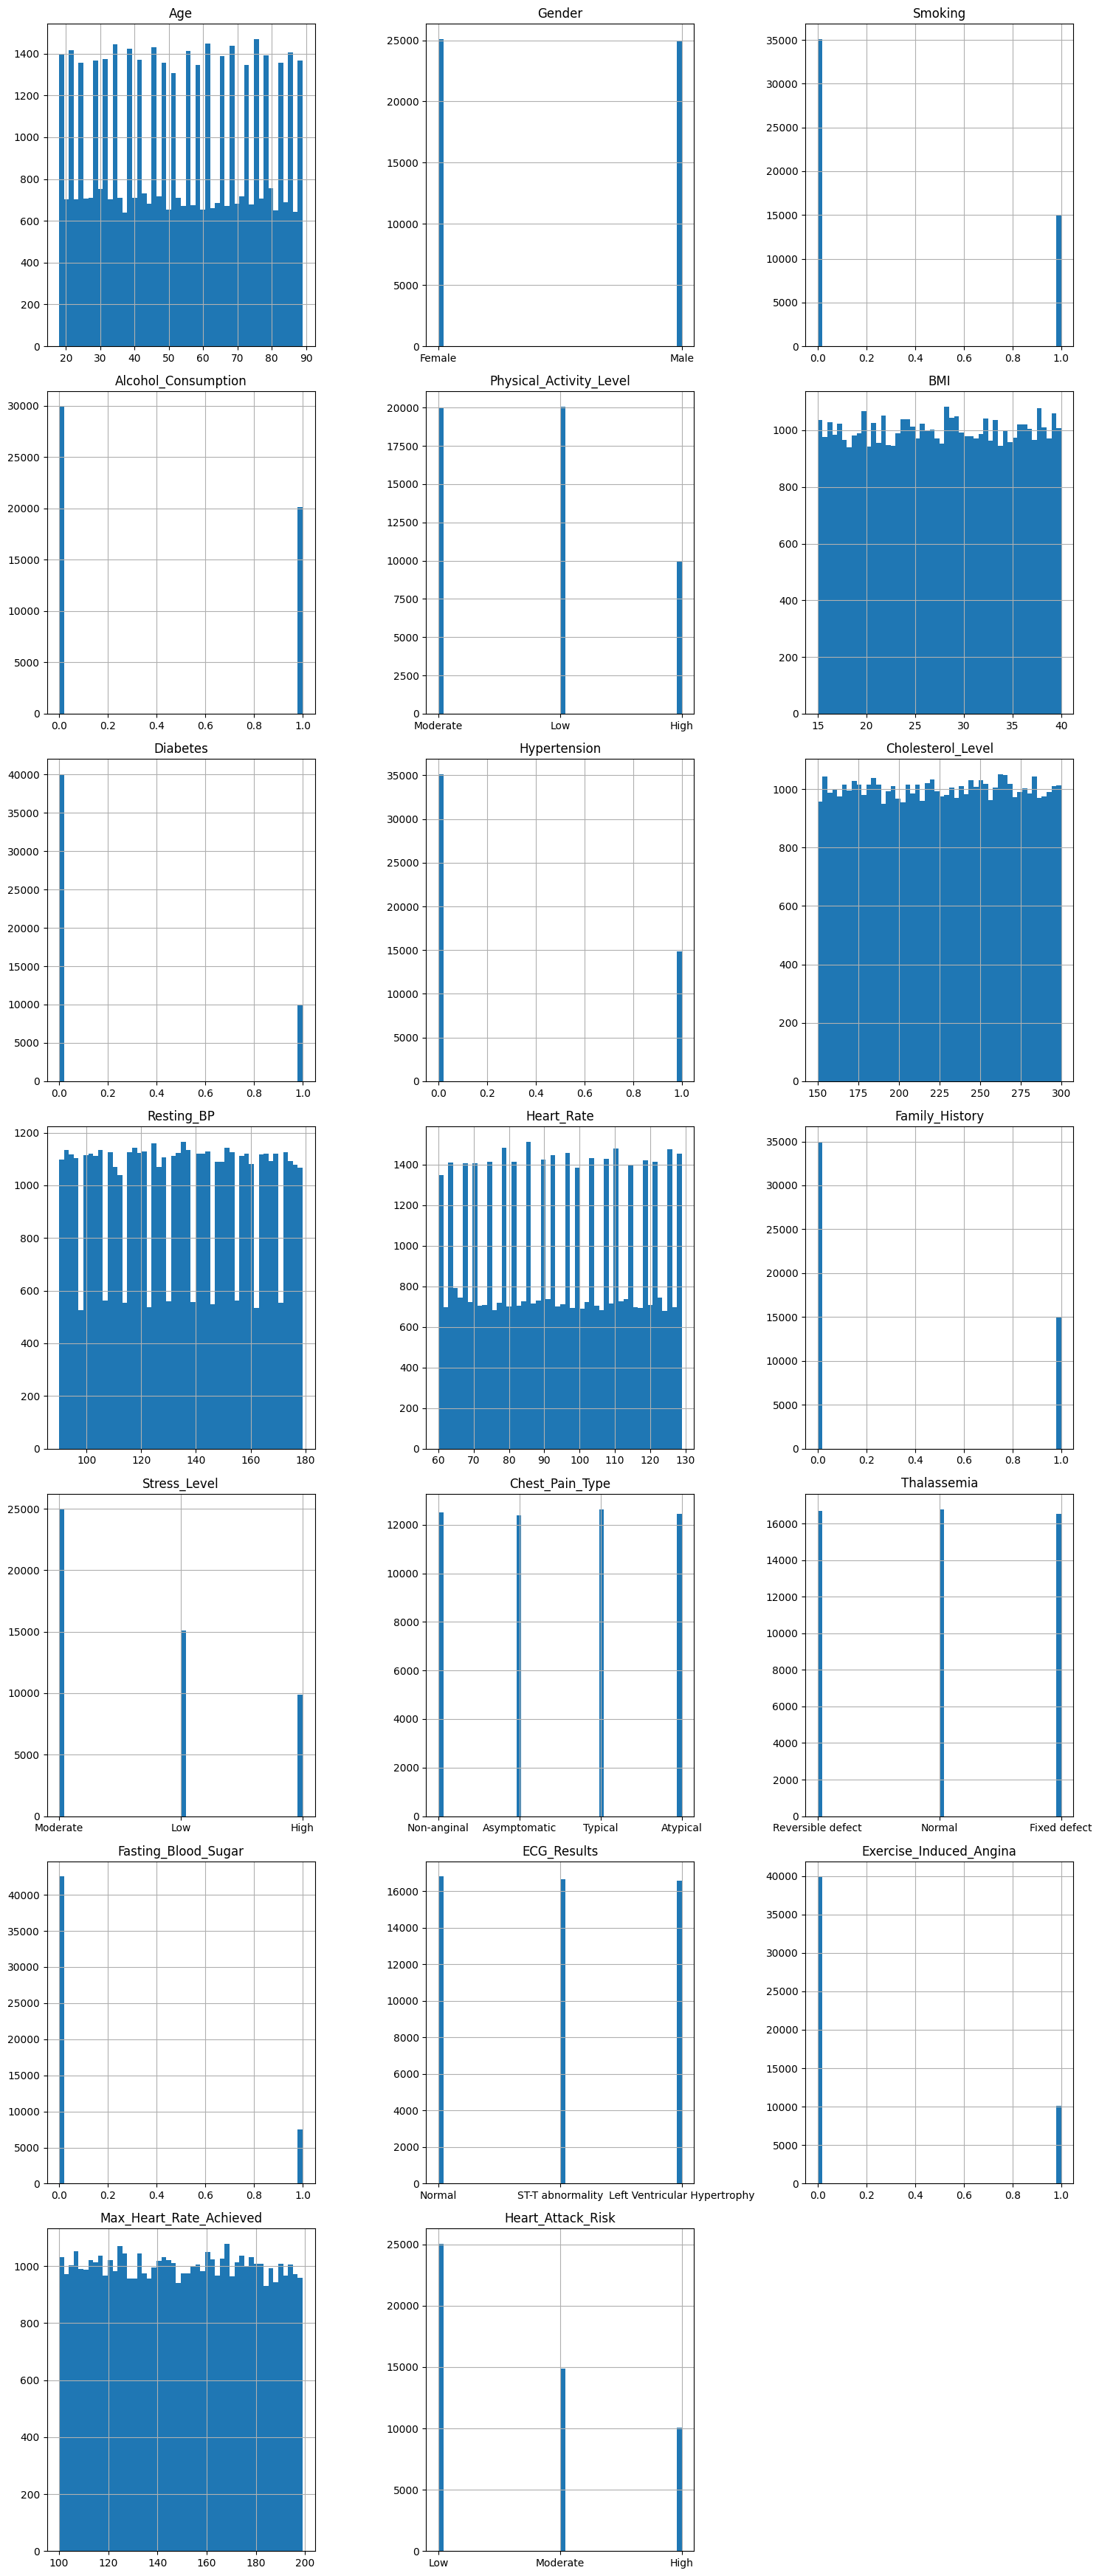

In [7]:
# We nemen eerst een snelle blik op de variabelen via een histogram plot van alle features
# We maken een algemene plot van de variabelen

if plot_graphs:
    num_columns = 3
    num_plots = len(df.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df.columns):
        df[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("algemeen_overzicht_features")
    plt.show()

outlier
-1    46505
 1     3495
Name: count, dtype: int64
93.01


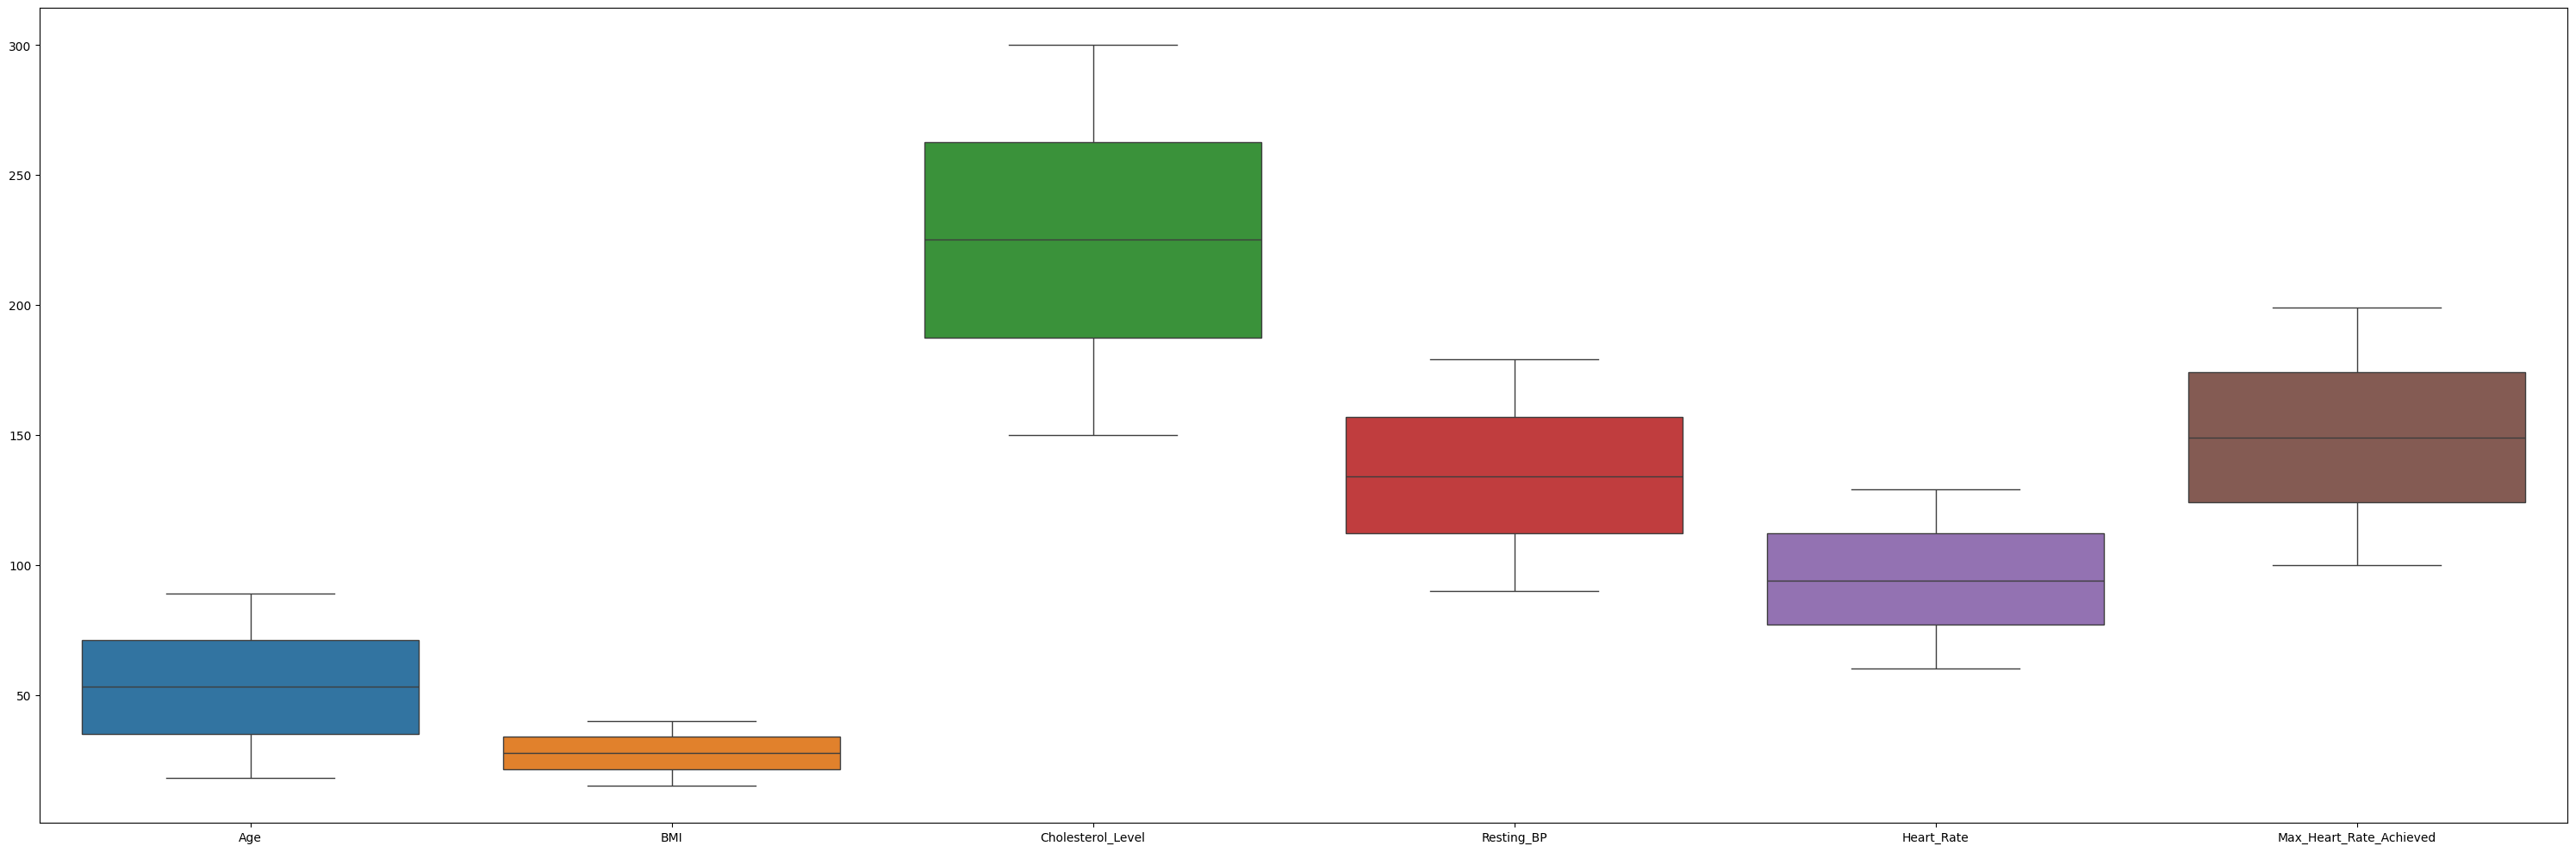

C:\Users\geert\AppData\Local\Temp\ipykernel_21760\1576076901.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_21760\1576076901.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_21760\1576076901.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_21760\1576076901.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_21760\1576076901.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\g

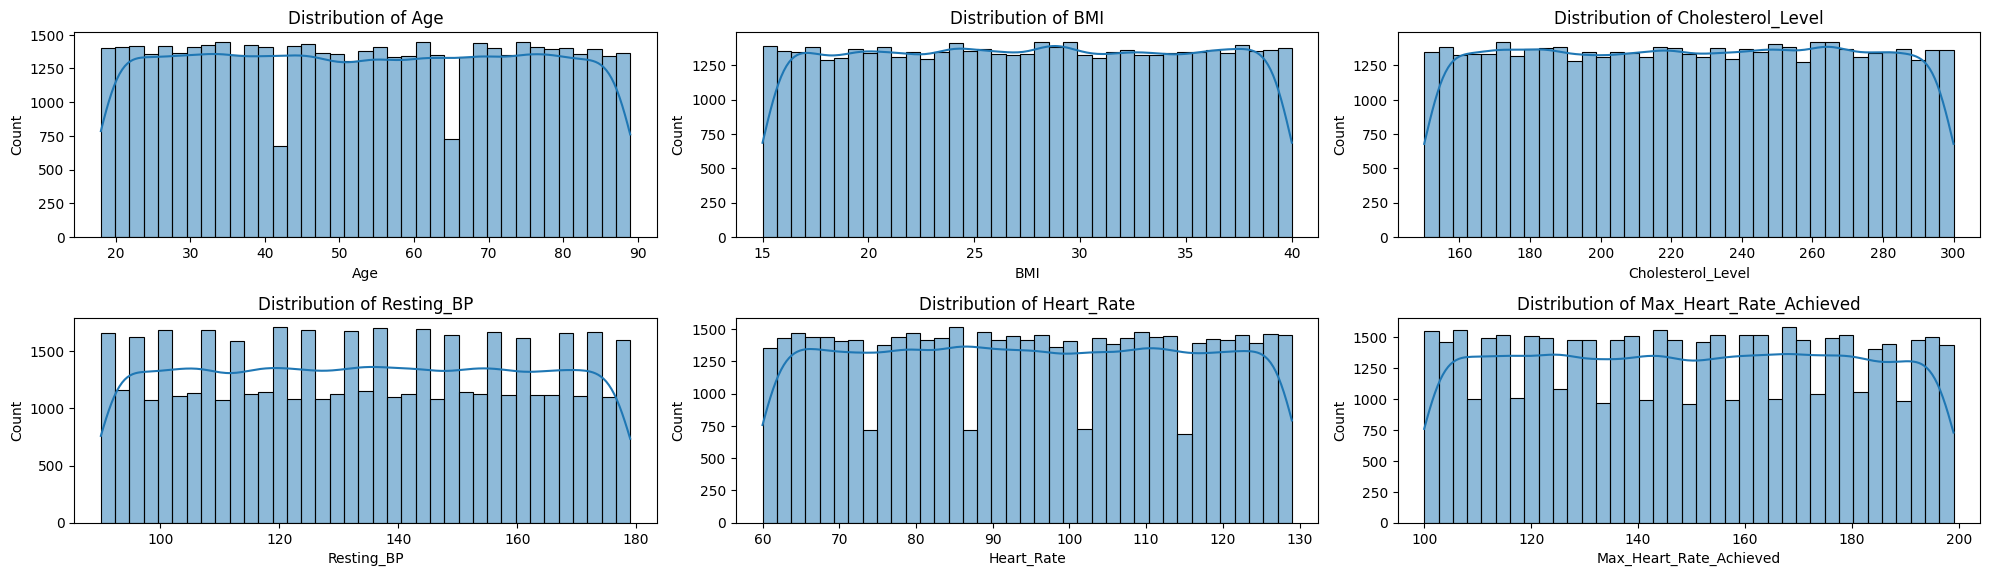

In [8]:
# analyze van de features, eerst de numerische features
# eerst een boxplot, voor de numerische waarde

# outliers berekenen maar hier doen we voorlopig niets mee
# dit lijkt hoog te zijn maar we gaan dit niet gebruiken
aantal_outliers = bereken_percentage_aantal_outliers(df,['Age'])
print(aantal_outliers)

# eerste een box-plot van de numerische variabelen
if plot_graphs:
    fig = plt.figure(figsize=(30,10))
    sns.boxplot(df_num)
    save_fig("Numerische features boxplot van de features")
    plt.show()
# Dit lijkt een normale verdeling. Er is hier geen log-verfijning nodig
# Er zijn ook geen outliers

# We maken nog een apart histogram van de numersiche variabelen
plt.figure(figsize=(20,14))
for i, col in enumerate(df_num_col,1):
    plt.subplot(5,3,i)
    sns.histplot(df[col], kde=True, palette='skyblue')
    plt.title(f"Distribution of {col}")
if plot_graphs:
    plt.tight_layout()
    save_fig("Numerische features histogram van de features")
    plt.show()
# Alles lijkt ook hier normaal



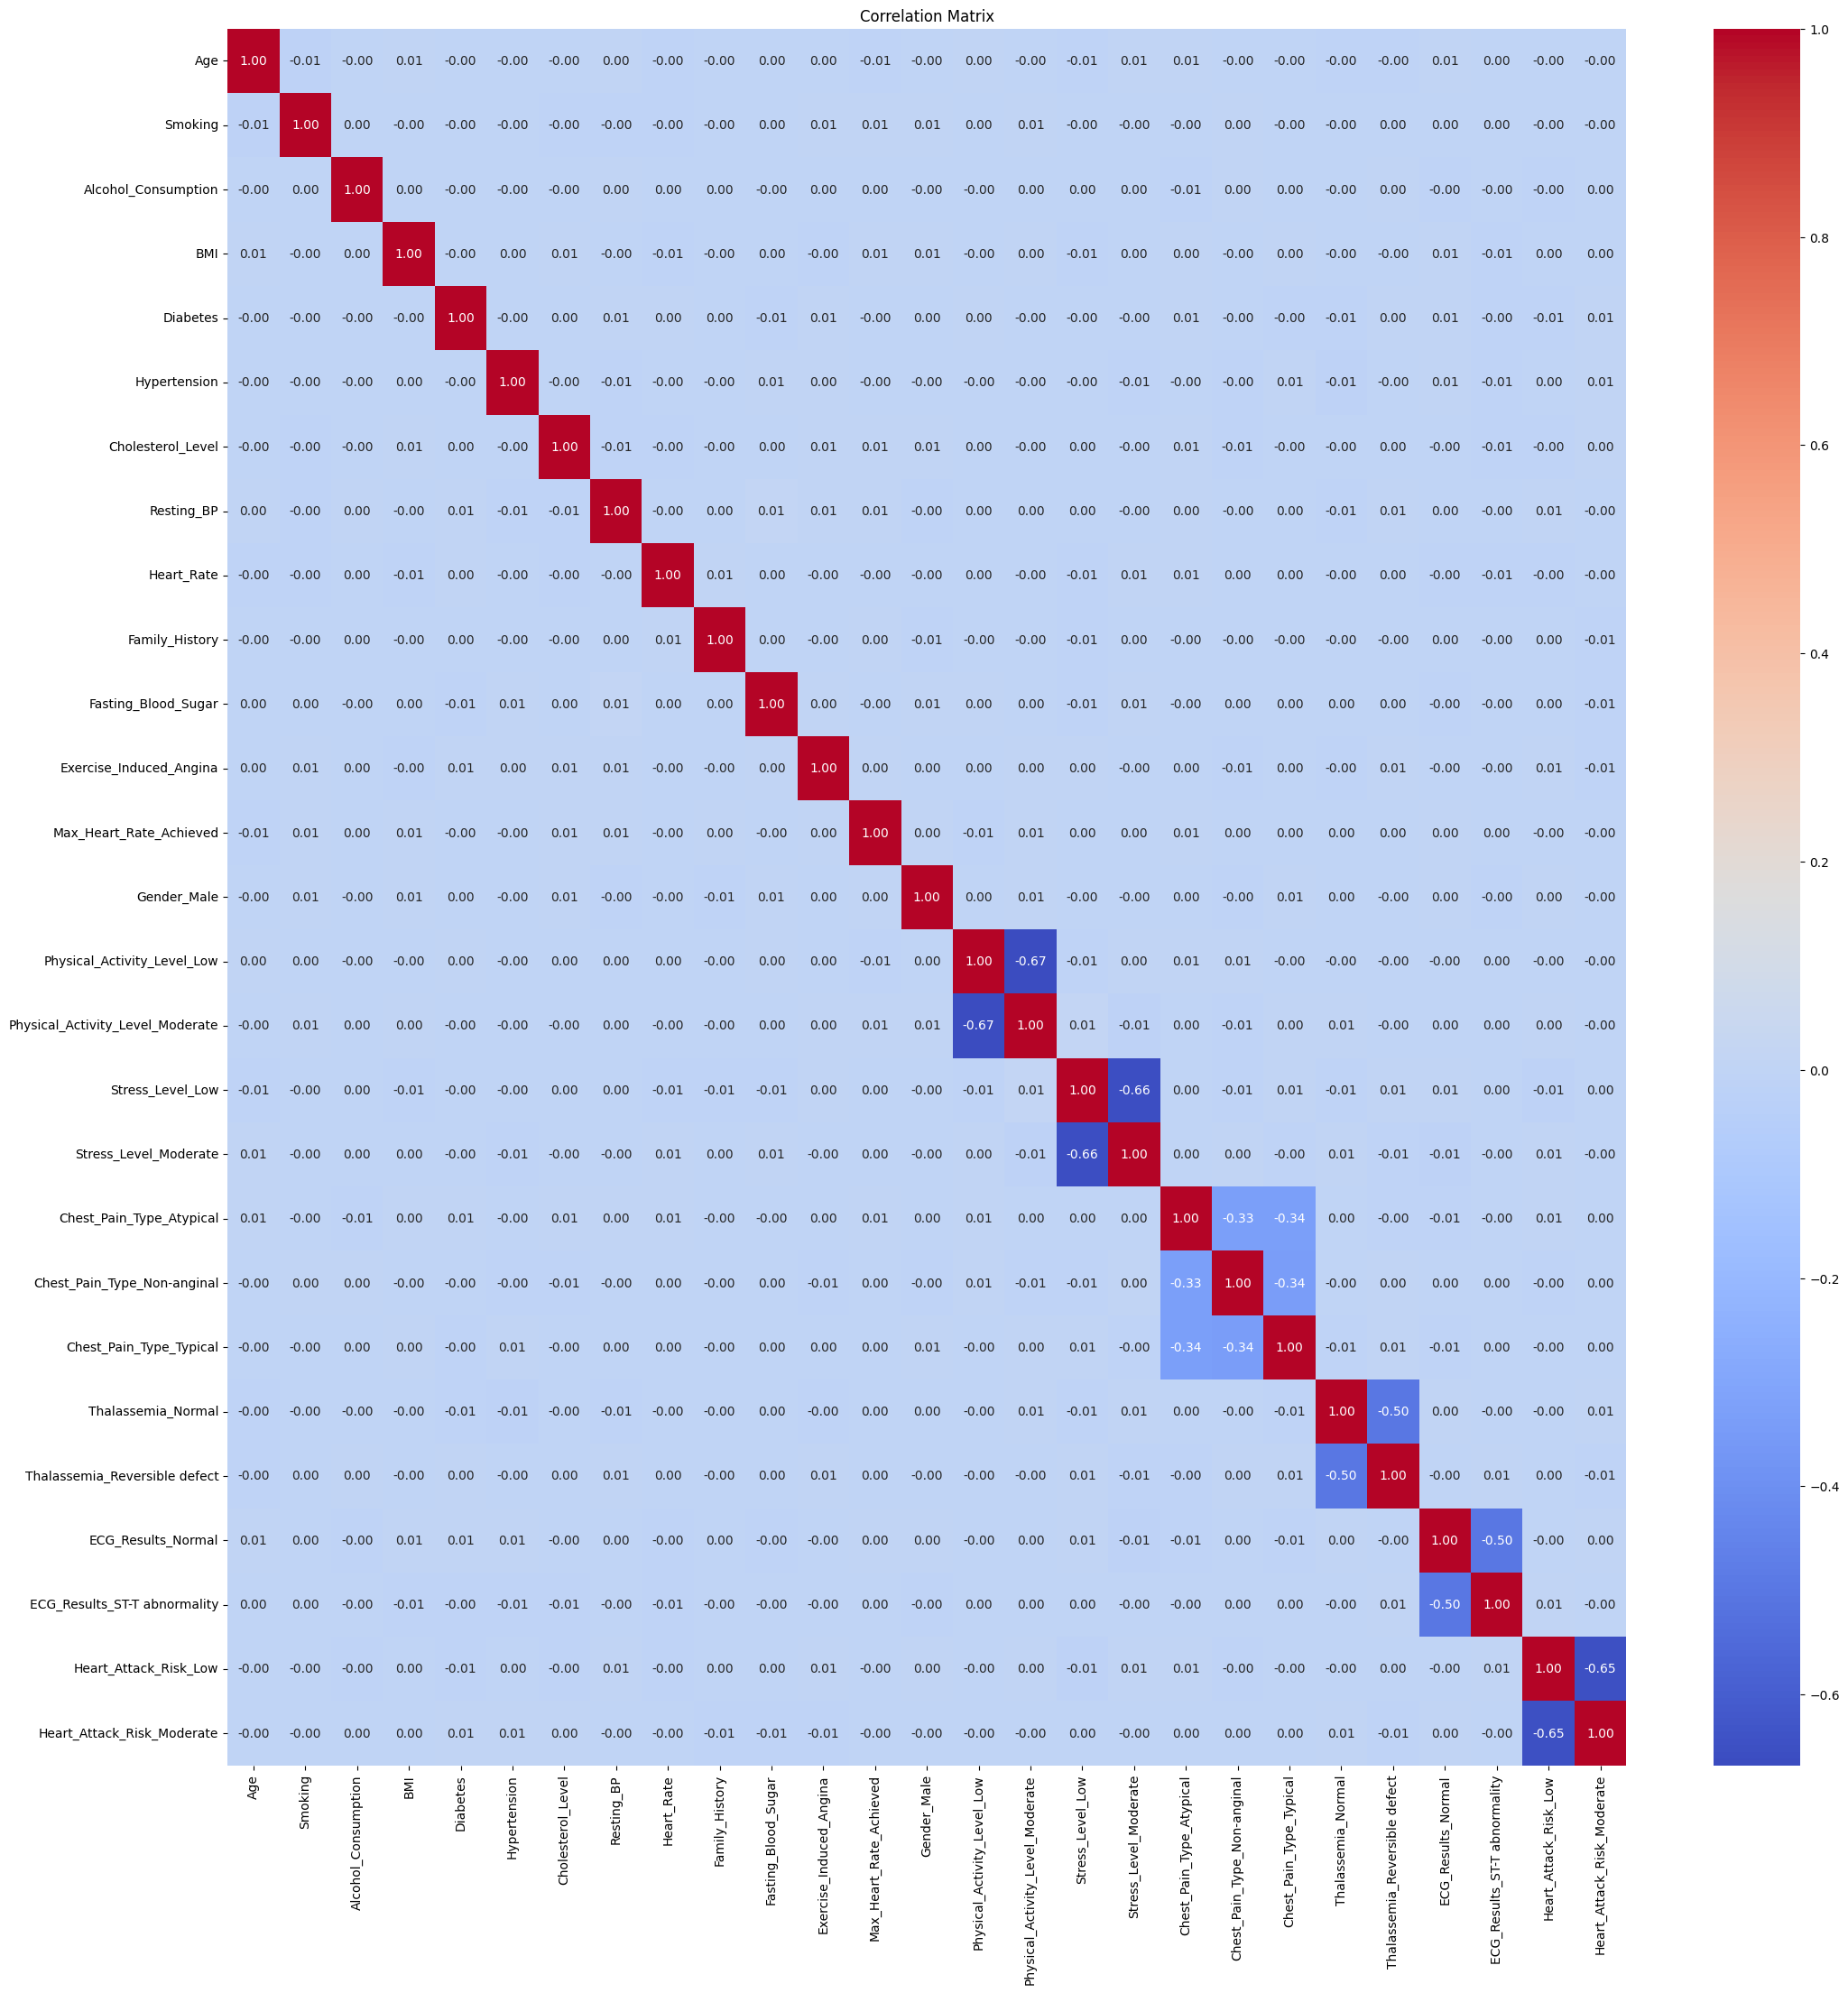

In [9]:
# check correlatie tussen de diverse features

data_num = pd.get_dummies(df, columns=['Gender','Physical_Activity_Level', 'Stress_Level','Chest_Pain_Type', 'Thalassemia', 'ECG_Results', 'Heart_Attack_Risk'], drop_first=True)

plt.figure(figsize=(25,25))
sns.heatmap(data_num.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# weinig correlatie tussen de features
# we kunnen de features dus behouden

In [10]:
# analyze van de categorische features
print(df_cat.head())
print(df_cat.describe())

   Smoking                   ECG_Results Stress_Level Heart_Attack_Risk  \
0        1                        Normal     Moderate               Low   
1        0              ST-T abnormality          Low          Moderate   
2        0              ST-T abnormality          Low               Low   
3        0  Left Ventricular Hypertrophy          Low               Low   
4        1              ST-T abnormality         High          Moderate   

  Chest_Pain_Type        Thalassemia  Exercise_Induced_Angina  Gender  \
0     Non-anginal  Reversible defect                        0  Female   
1    Asymptomatic             Normal                        0    Male   
2         Typical  Reversible defect                        0    Male   
3         Typical       Fixed defect                        0    Male   
4    Asymptomatic  Reversible defect                        0  Female   

   Diabetes  Fasting_Blood_Sugar Physical_Activity_Level  Family_History  \
0         1                    0  

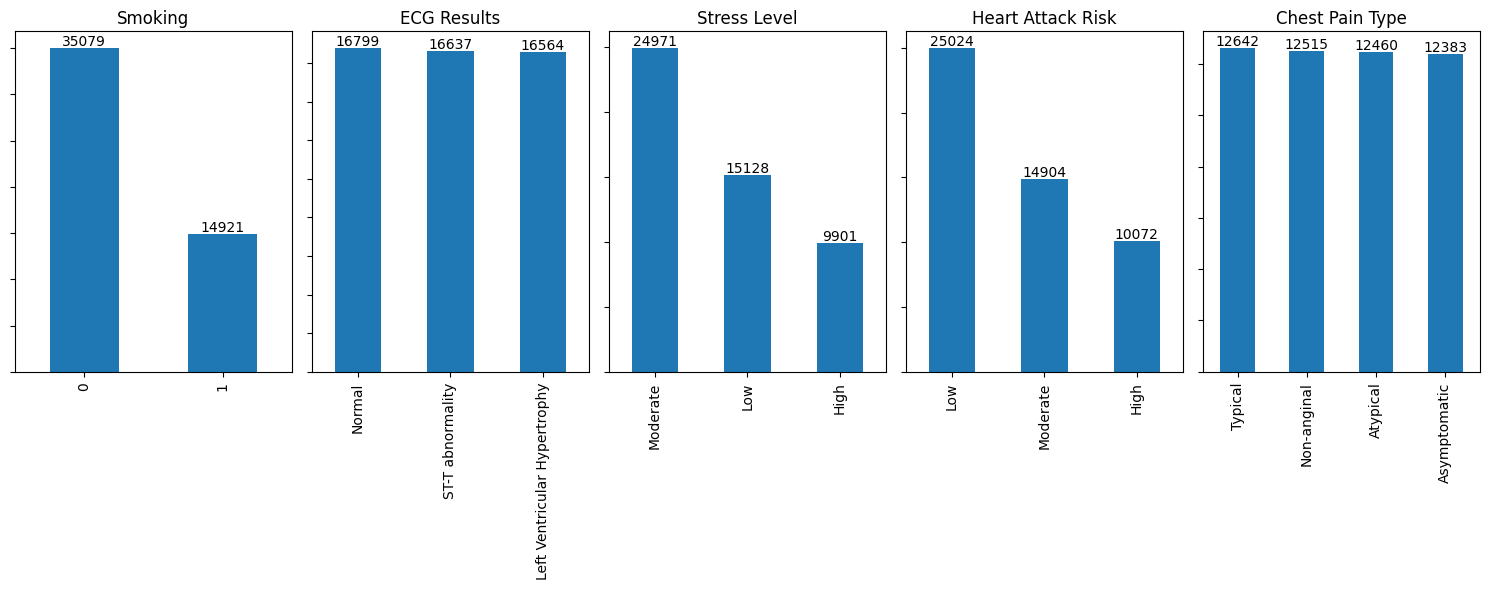

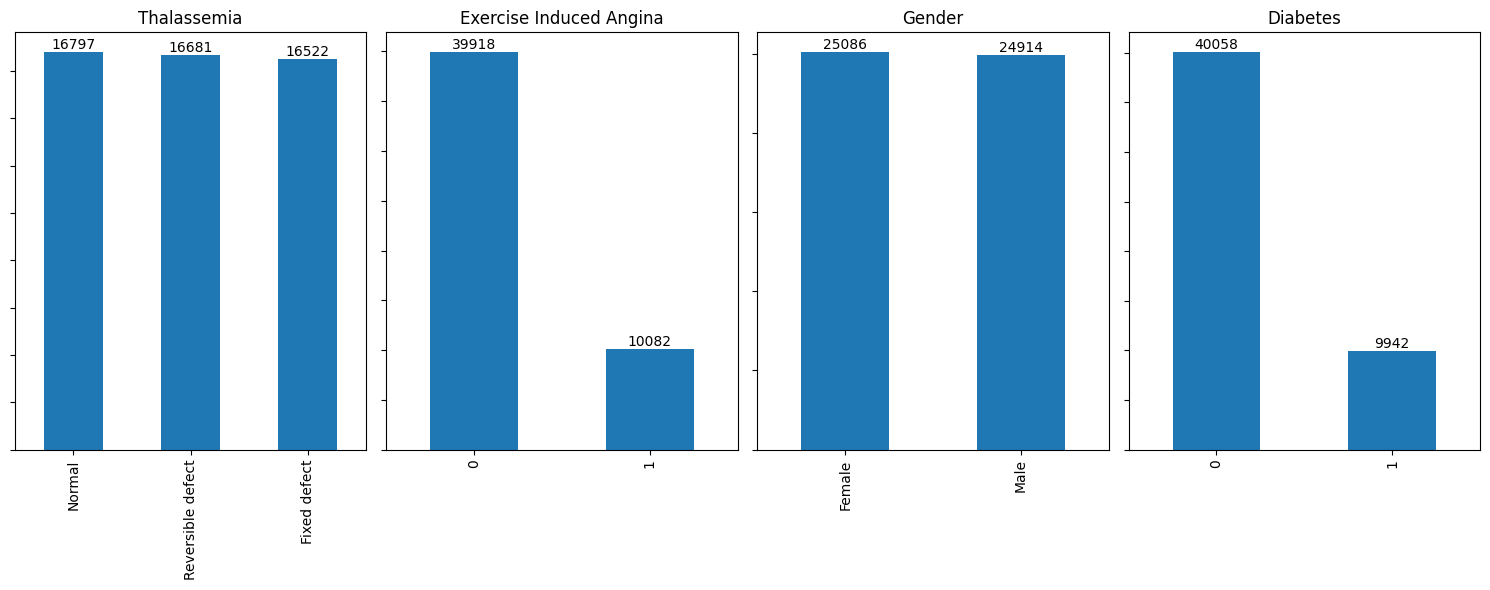

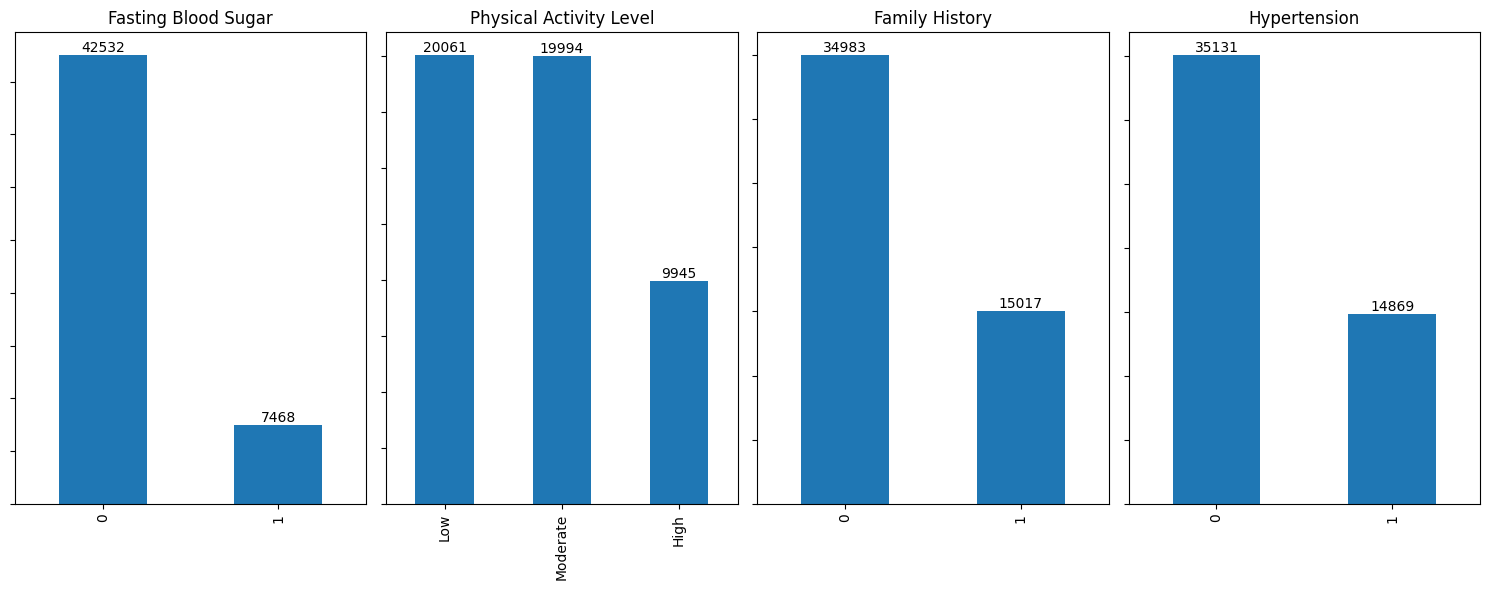

In [11]:
# maak per categorsiche variabel een bar_plot van de voorkomens van de waarden
def bar_labels(axes, rotation= 0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

# plot de categorische waarde af met het voorkomen van de waarde in de dataset
# 14 plots, opgedeeld in 2 rijen met 7 plots

if plot_graphs:
    index = 0
    for r in [5,4,4]:
        fig, axes = plt.subplots(ncols=r, figsize=(15, 6))
        for i in range(r):
            df[df_cat_col[index]].value_counts().plot(kind="bar", ax=axes[i])
            bar_labels(axes[i])
            axes[i].set_title(df_cat_col[index].replace('_', ' '))            
            index+=1      
        plt.tight_layout()   
        save_fig(f"Categorische features value count van de feature deel{r}")
        plt.show()


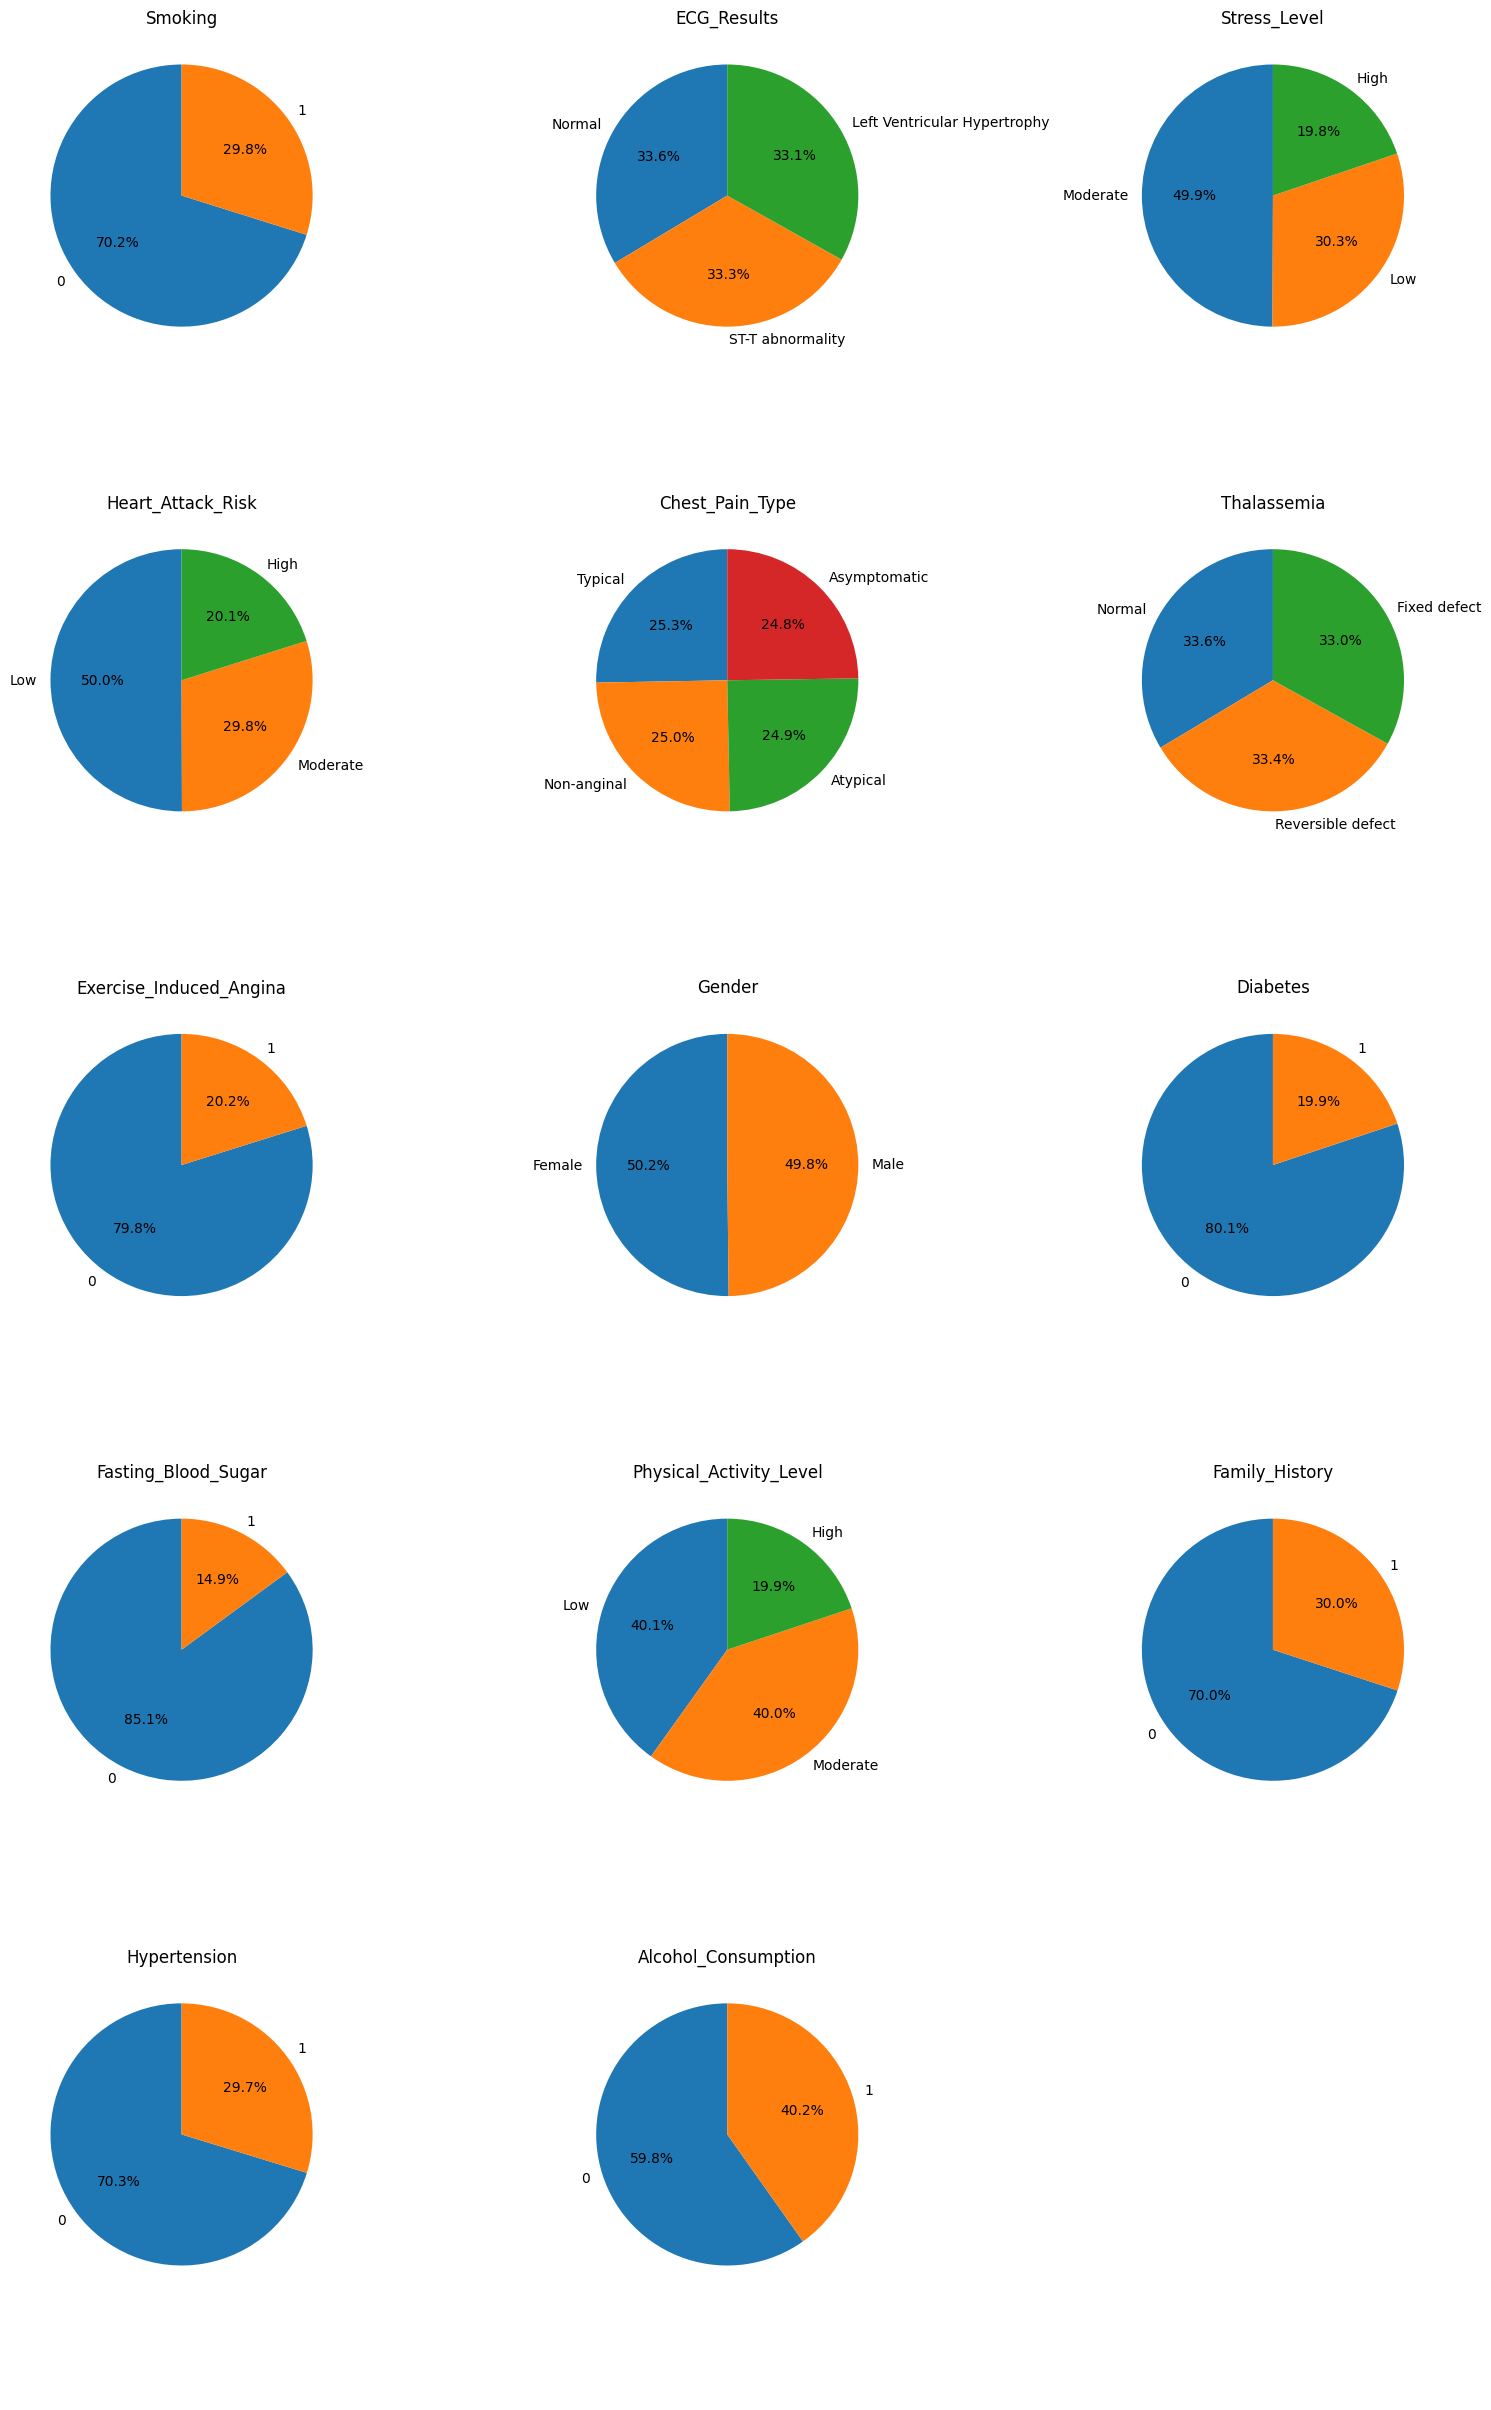

In [12]:
# visuele voorstellen van de unbalance van de categorische variabelen
# Creëer een figuur en een set van subplots
num_columns = 3
num_plots = len(df_cat.columns)
num_rows = (num_plots + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten het axes object voor eenvoudiger iteratie
axes = axes.flatten()

# Loop over alle kolommen en creëer een pie chart voor elke kolom
for i, column in enumerate(df_cat.columns):
    # Haal de waarde tellingen op voor de huidige kolom
    counts = df_cat[column].value_counts()
    
    # Maak een pie chart op de i-th positie in axes
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(column)
    axes[i].set_ylabel('')  # Verwijder de y-label voor netheid

# Verberg eventuele extra subplots als het aantal kolommen minder is dan het aantal subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Toon de plot
plt.tight_layout()
save_fig(f"Categorische features unbalance view")
plt.show()



In [13]:
# SMOTE toepassen
# we gaan dit later mee in de pipelining integreren om te kijken wat het effect van SMOTE kan zijn
# sample test

# Voorbeeld dataset genereren
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

# Data in een DataFrame plaatsen voor visualisatie
df_smote = pd.DataFrame(X)
df_smote['target'] = y

# Toon de klasse distributie voor SMOTE
print('Originele dataset shape %s' % Counter(y))

# Pas SMOTE toe
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Resampled dataset shape %s' % Counter(y_res))

# Toon de originele klasse distributie
print('Originele dataset shape %s' % Counter(y))

# Configureer de RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Dataset shape na undersampling %s' % Counter(y_res_under))


Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Resampled dataset shape Counter({np.int64(0): 900, np.int64(1): 900})
Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Dataset shape na undersampling Counter({np.int64(0): 100, np.int64(1): 100})


c:\data\repos\data_science_cases\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Het systeem kan het opgegeven bestand niet vinden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\data\repos\data_science_cases\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\geert\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\geert\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\geert\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, i

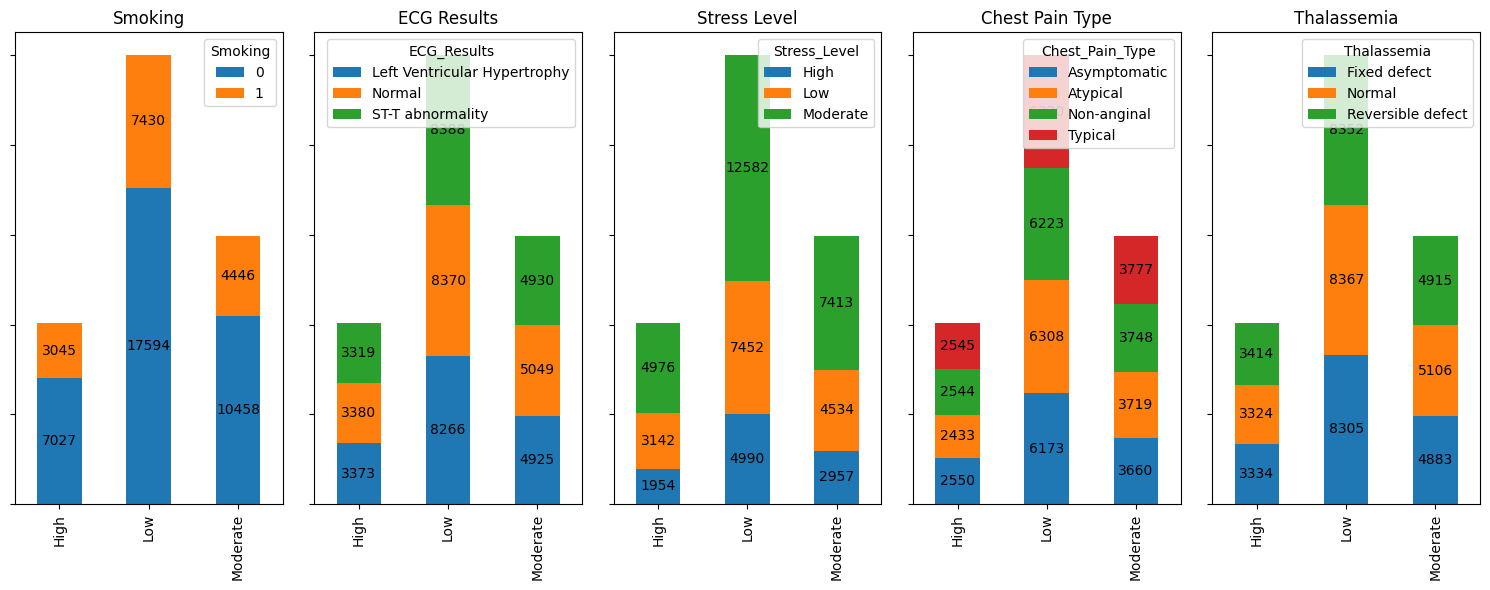

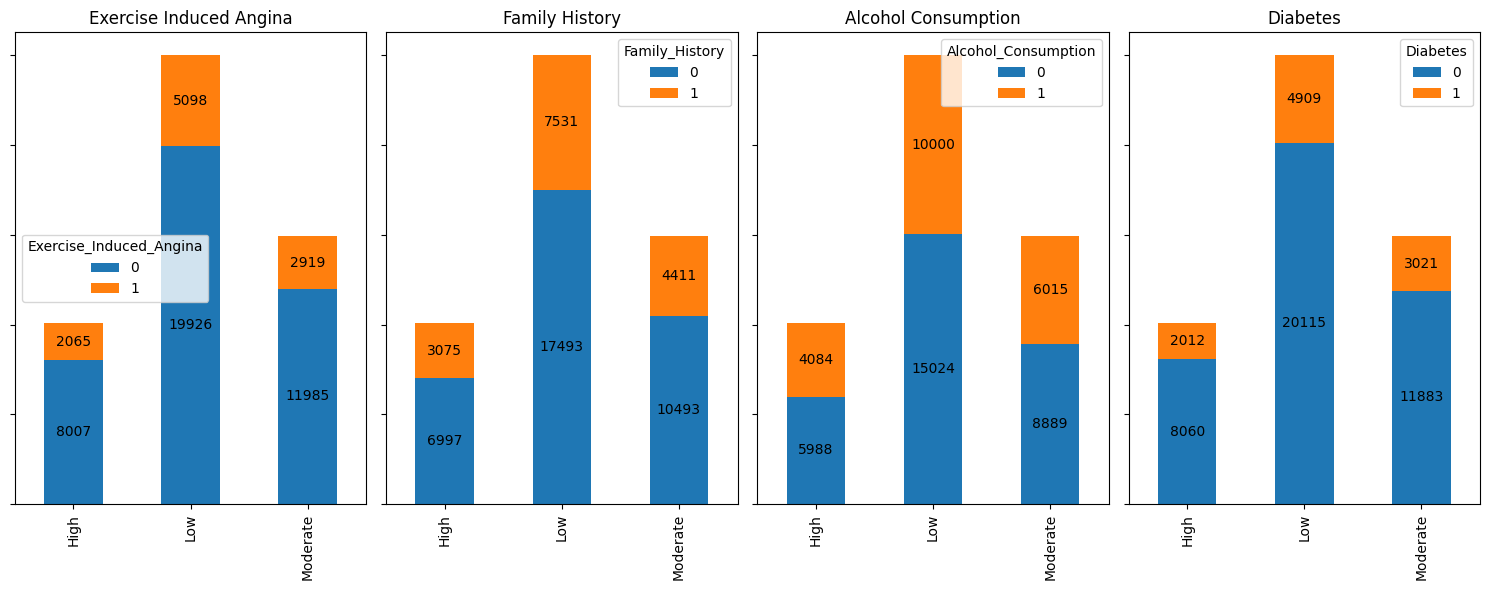

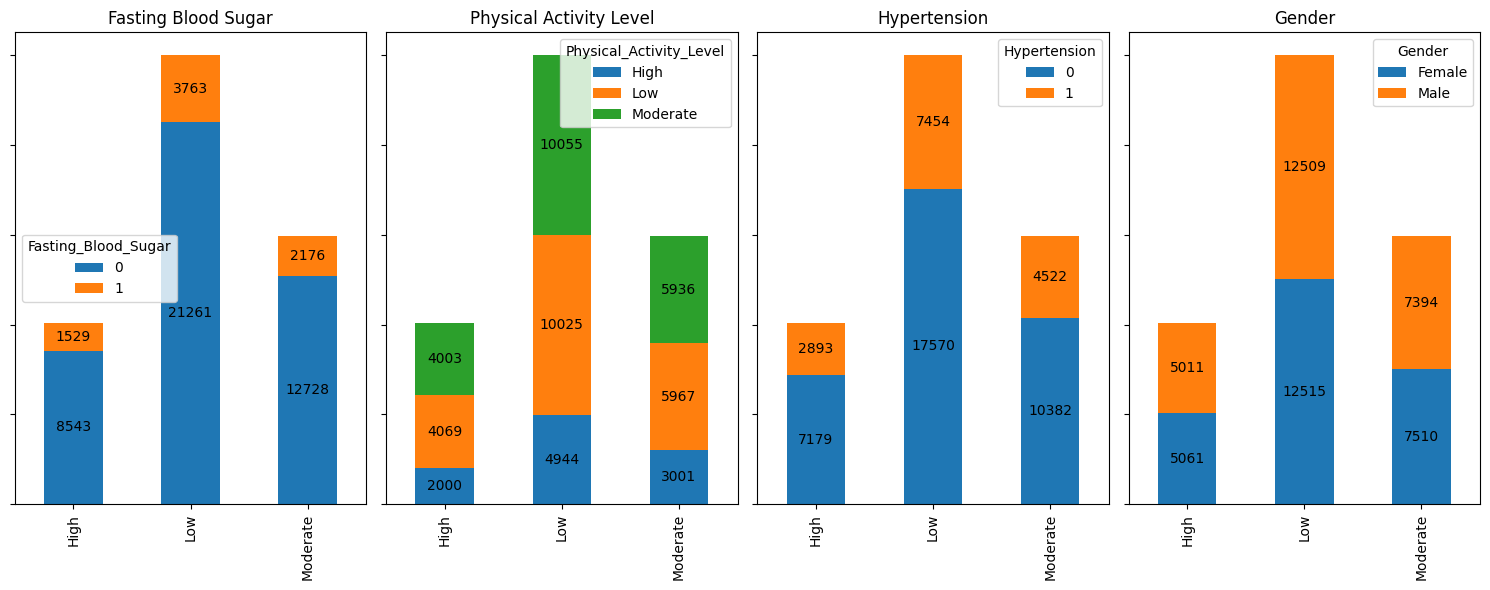

In [14]:
# en nu gaan we op basis van de target value ("Heart risk") groeperen en kijken wat de impact is van de diverse
# categorische variabelen

index = 0
grouped = df.groupby(df_label_col)
df_group_cols = list(set(df_cat_col) - set(df_label_col))
# plot 13 grafieken, 
if plot_graphs:
    for j in [5, 4, 4]:
        fig, axes = plt.subplots(ncols=j, figsize=(15, 6))
        for i in range(j):
            grouped[df_group_cols[index]].value_counts().unstack().plot(kind="bar", stacked=True, ax=axes[i])
            bar_labels(axes[i], 0, "center")
            axes[i].set_title(df_group_cols[index].replace('_', ' '))
            index+=1
        plt.tight_layout()
        save_fig(f"Categorische features per value van de target value deel {r}")
        plt.show()

Hier beginnen we met de modellen

Eerst een eenvoudige logistic regression, met stratefy op de target value
Eerst zonder SMOTE, dan met parameter class_weight = 'balanced" en dan eens met SMOTE om te zien wat het effect is van het aanpakken van de unbalanced data

16/02/2025 11:31:38 : Info : 


16/02/2025 11:31:38 : Info : Eenvoudige logistic regression met stratify op de target value zonder SMOTE
16/02/2025 11:31:38 : Info : **************************************************************
16/02/2025 11:31:38 : Info : Voorkomens in y_pred: Counter({'Low': 10000})
16/02/2025 11:31:38 : Info : Voorkomens in y_test: Counter({'Low': 5005, 'Moderate': 2981, 'High': 2014})


c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/02/2025 11:31:38 : Info : 
accuracy_score: 50.05
16/02/2025 11:31:38 : Info : classification_report:               precision    recall  f1-score   support

        High       0.00      0.00      0.00         0
         Low       1.00      0.50      0.67     10000
    Moderate       0.00      0.00      0.00         0

    accuracy                           0.50     10000
   macro avg       0.33      0.17      0.22     10000
weighted avg       1.00      0.50      0.67     10000

16/02/2025 11:31:38 : Info : Confusion matrix: +------+------+------+
|    0 |    1 |    2 |
|------+------+------|
|    0 |    0 |    0 |
| 2014 | 5005 | 2981 |
|    0 |    0 |    0 |
+------+------+------+


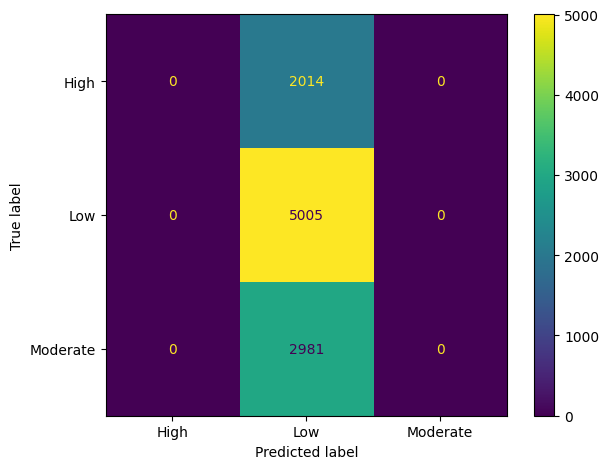

In [15]:
# Eenvoudige Logistic regression met pipeline opzet 
# met stratefy op de target value
# en zonder

log_info("\n\n")
log_info(f"Eenvoudige logistic regression met stratify op de target value zonder SMOTE")
log_info("**************************************************************")

df = df_raw.copy()

# Separate features (X) and target variable (y)
X = df.drop(columns=['Heart_Attack_Risk'])
y = df['Heart_Attack_Risk']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define categorical and numerical column names
df_col = X.columns  
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))

num_pipeline = Pipeline([   
    ("standardize_numerical", MinMaxScaler(feature_range=(-1, 1)))
    # ("standardize_numerical", StandardScaler())
])

cat_pipeline = Pipeline(steps=[   
    ('encode_categorical', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ("numerical", num_pipeline, df_num_col),
    ("categorical", cat_pipeline, df_cat_col)],
     remainder='passthrough')

# Create the pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),       
    ('regressor', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

y_pred_counter = Counter(y_pred)
y_test_counter = Counter(y_test)
log_info(f"Voorkomens in y_pred: {y_pred_counter}")
log_info(f"Voorkomens in y_test: {y_test_counter}")

acc_score = accuracy_score(y_pred, y_test)*100
class_report = classification_report(y_pred, y_test)
conf_matrix = confusion_matrix(y_pred, y_test)

log_info(f"\naccuracy_score: {acc_score}")
log_info(f"classification_report: {class_report}")
summary_conf_matrix = tabulate(conf_matrix, headers='keys', tablefmt='psql')
log_info(f"Confusion matrix: {summary_conf_matrix}")

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
save_fig("Confusion matrix - example logistic regression zonder SMOTE")


16/02/2025 11:31:38 : Info : 


16/02/2025 11:31:38 : Info : Eenvoudige logistic regression met stratify op de target value en class weight = balanced
16/02/2025 11:31:38 : Info : ******************************************************************************************
16/02/2025 11:31:38 : Info : Voorkomens in y_pred: Counter({'High': 3534, 'Moderate': 3358, 'Low': 3108})
16/02/2025 11:31:38 : Info : Voorkomens in y_test: Counter({'Low': 5005, 'Moderate': 2981, 'High': 2014})
16/02/2025 11:31:38 : Info : 
accuracy_score: 32.629999999999995
16/02/2025 11:31:38 : Info : classification_report:               precision    recall  f1-score   support

        High       0.36      0.21      0.26      3534
         Low       0.30      0.49      0.37      3108
    Moderate       0.34      0.30      0.32      3358

    accuracy                           0.33     10000
   macro avg       0.34      0.33      0.32     10000
weighted avg       0.34      0.33      0.32     10000

16/02/2025 11:31:38

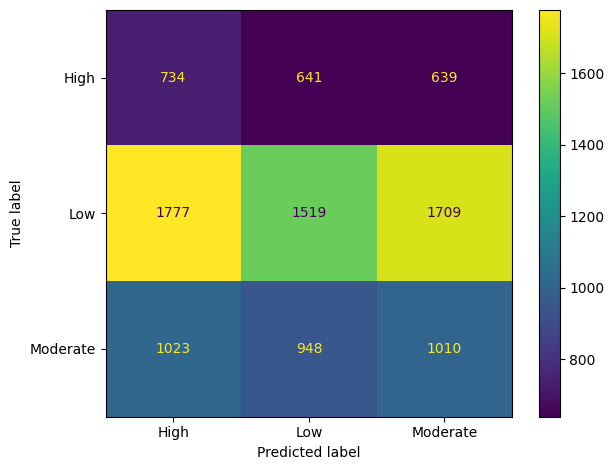

In [16]:
# Eenvoudige Logistic regression met pipeline opzet 
# met stratefy op de target value
# en nu eens met de parameter class_weight='balanced' voor de logistic regression

log_info("\n\n")
log_info(f"Eenvoudige logistic regression met stratify op de target value en class weight = balanced")
log_info("******************************************************************************************")

df = df_raw.copy()

# Separate features (X) and target variable (y)
X = df.drop(columns=['Heart_Attack_Risk'])
y = df['Heart_Attack_Risk']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define categorical and numerical column names
df_col = X.columns  
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))

num_pipeline = Pipeline([   
    ("standardize_numerical", MinMaxScaler(feature_range=(-1, 1)))
    # ("standardize_numerical", StandardScaler())
])

cat_pipeline = Pipeline(steps=[   
    ('encode_categorical', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ("numerical", num_pipeline, df_num_col),
    ("categorical", cat_pipeline, df_cat_col)],
     remainder='passthrough')

# Create the pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),       
    ('regressor', LogisticRegression(class_weight='balanced'))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

y_pred_counter = Counter(y_pred)
y_test_counter = Counter(y_test)
log_info(f"Voorkomens in y_pred: {y_pred_counter}")
log_info(f"Voorkomens in y_test: {y_test_counter}")

acc_score = accuracy_score(y_pred, y_test)*100
class_report = classification_report(y_pred, y_test)
conf_matrix = confusion_matrix(y_pred, y_test)

log_info(f"\naccuracy_score: {acc_score}")
log_info(f"classification_report: {class_report}")
summary_conf_matrix = tabulate(conf_matrix, headers='keys', tablefmt='psql')
log_info(f"Confusion matrix: {summary_conf_matrix}")

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
save_fig("Confusion matrix - example logistic regression met class weight = balanced")


Eenvoudige logistic regression met pipeline opzet en met SMOTE
Om te checken of SMOTE bijdraagt tot een beter resultaat

Het resultaat is anders. Zonder SMOTE of class_weight=balanced, hebben in de predicted waarde enkel predictie op LOW.
Bij SMOTE en bij class_weight=balanced hebben we predictie op LOW, MODERATE en HIGH

Voor de vervolg regressie passen we geen SMOTE meer toe

Dit kan in een vervolgopdracht nog verder onderzocht worden

16/02/2025 11:31:39 : Info : 


16/02/2025 11:31:39 : Info : Eenvoudige logistic regression met SMOTE en met stratify op de target value
16/02/2025 11:31:39 : Info : ********************************************************************
16/02/2025 11:31:39 : Info : Voorkomens in y_pred: Counter({'High': 3596, 'Low': 3377, 'Moderate': 3027})
16/02/2025 11:31:39 : Info : Voorkomens in y_test: Counter({'Low': 5005, 'Moderate': 2981, 'High': 2014})
16/02/2025 11:31:39 : Info : 
accuracy_score: 33.739999999999995
16/02/2025 11:31:39 : Info : classification_report:               precision    recall  f1-score   support

        High       0.21      0.37      0.26      2014
         Low       0.50      0.34      0.41      5005
    Moderate       0.31      0.31      0.31      2981

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.33     10000
weighted avg       0.39      0.34      0.35     10000

16/02/2025 11:31:39 : Info : Confusion matrix: +------+

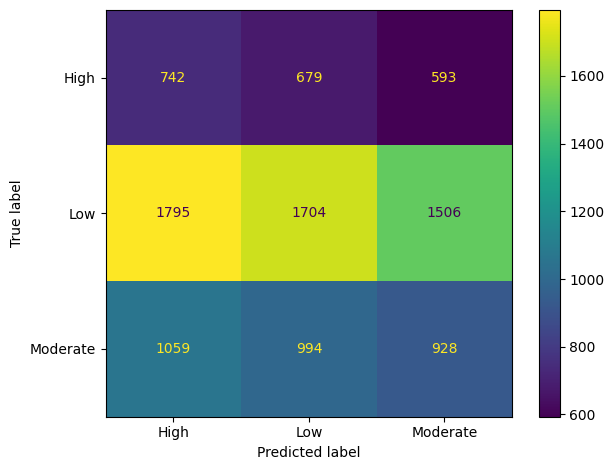

In [17]:
# Eenvoudige Logistic regression met pipeline opzet en met SMOTE
# met stratefy op de target value

log_info("\n\n")
log_info(f"Eenvoudige logistic regression met SMOTE en met stratify op de target value")
log_info("********************************************************************")

df = df_raw.copy()

# Separate features (X) and target variable (y)
X = df.drop(columns=['Heart_Attack_Risk'])
y = df['Heart_Attack_Risk']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define categorical and numerical column names
df_col = X.columns  
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))

num_pipeline = Pipeline([   
    ("standardize_numerical", MinMaxScaler(feature_range=(-1, 1)))
    # ("standardize_numerical", StandardScaler())
])

cat_pipeline = Pipeline(steps=[   
    ('encode_categorical', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ("numerical", num_pipeline, df_num_col),
    ("categorical", cat_pipeline, df_cat_col)],
     remainder='passthrough')

# Create the pipeline with preprocessing and logistic regression
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),      
    ('regressor', LogisticRegression(class_weight='balanced'))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

y_pred_counter = Counter(y_pred)
y_test_counter = Counter(y_test)
log_info(f"Voorkomens in y_pred: {y_pred_counter}")
log_info(f"Voorkomens in y_test: {y_test_counter}")

acc_score = accuracy_score(y_test, y_pred)*100
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

log_info(f"\naccuracy_score: {acc_score}")
log_info(f"classification_report: {class_report}")
summary_conf_matrix = tabulate(conf_matrix, headers='keys', tablefmt='psql')
log_info(f"Confusion matrix: {summary_conf_matrix}")

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
save_fig("Confusion matrix - example logistic regression met SMOTE")



Nu gaan we voor een aantal classificatie modellen met opzet van pipeling.

Zonder SMOTE omdat dit niet echt bijdraagt tot het resultaat, wel met de parameter class_weight='balanced' voor LogisticRegression

In [18]:
# en nu gaan we voor een aantal classificatie modellen dit uitvoeren
# en checken wat het beste model is tot nu toe
# zonder SMOTE omdat we merken dat SMOTE niet bijdraagt aan een betere score
# we gebruiken wel de parameter class_weight='balanced' om de onbalans in de target value te compenseren

# duurt enkele minuten

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
lgr = LogisticRegression(class_weight='balanced')

models_cl = [rfc, abc, gbc, etc, lgr, svc]
# models_cl = [lgr, svc, abc]

names_cl = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees",
        "Logistic Regression", "Support Vector Machine"]
# names_cl = ["Logistic Regression", "Support Vector Machine","Gradient Boosting"]

def training_classification(X_train, X_test, y_train, y_test, preprocessor):    
    scores, scores_dict, reports, cms = [], dict(), dict(), dict()
    for i, j in zip(models_cl, names_cl):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),                  
            ('regressor', i)            
            ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)*100
        scores += [acc_score]
        scores_dict[j] = [acc_score]    
        reports[j] = classification_report(y_test, y_pred)
        cms[j] = confusion_matrix(y_test, y_pred)
        log_info(f"\n\nExecuting classification for Model : {j}")
        #log_info("\n")
        #log_info(f"Accuracy scores: {acc_score}")
        #log_info(f"Confusion matrix: {cms[j]}") 
        #log_info(f"Classification report: {reports[j]}") 
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
        # disp.plot()
        fig_titel = f"ConfusionMatrixDisplay voor model {i}"
        save_fig(fig_titel)

    fig, axes = plt.subplots()
    df_results = pd.DataFrame({"score": scores}, index=names_cl)
    df_results = df_results.sort_values("score", ascending=False)

    index = 0
    for row in range(2):
        fig, axes = plt.subplots(ncols=3, figsize=(15, 6))        
        for i in range(3):
            sns.heatmap(cms[df_results.index[index]], annot=True, fmt='d', ax=axes[i])
            axes[i].set_title("{}: {}%".format(df_results.index[index], df_results.iloc[index, 0]))
            index += 1
        plt.tight_layout()
        plt.show()
   
    return scores_dict, reports, cms

16/02/2025 11:31:44 : Info : 

Executing classification for Model : Random Forest


c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metric

16/02/2025 11:31:47 : Info : 

Executing classification for Model : Ada Boost
16/02/2025 11:31:58 : Info : 

Executing classification for Model : Gradient Boosting
16/02/2025 11:32:02 : Info : 

Executing classification for Model : Extra Trees
16/02/2025 11:32:02 : Info : 

Executing classification for Model : Logistic Regression


c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

16/02/2025 11:34:12 : Info : 

Executing classification for Model : Support Vector Machine


<Figure size 640x480 with 0 Axes>

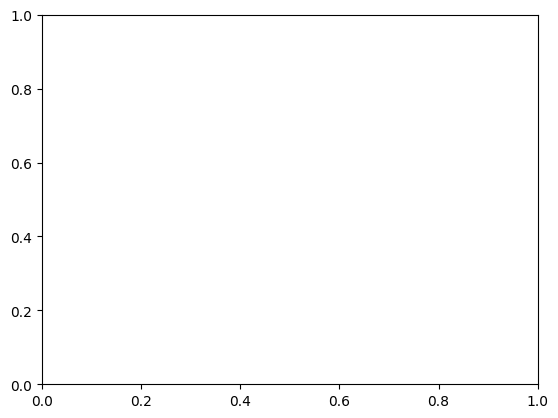

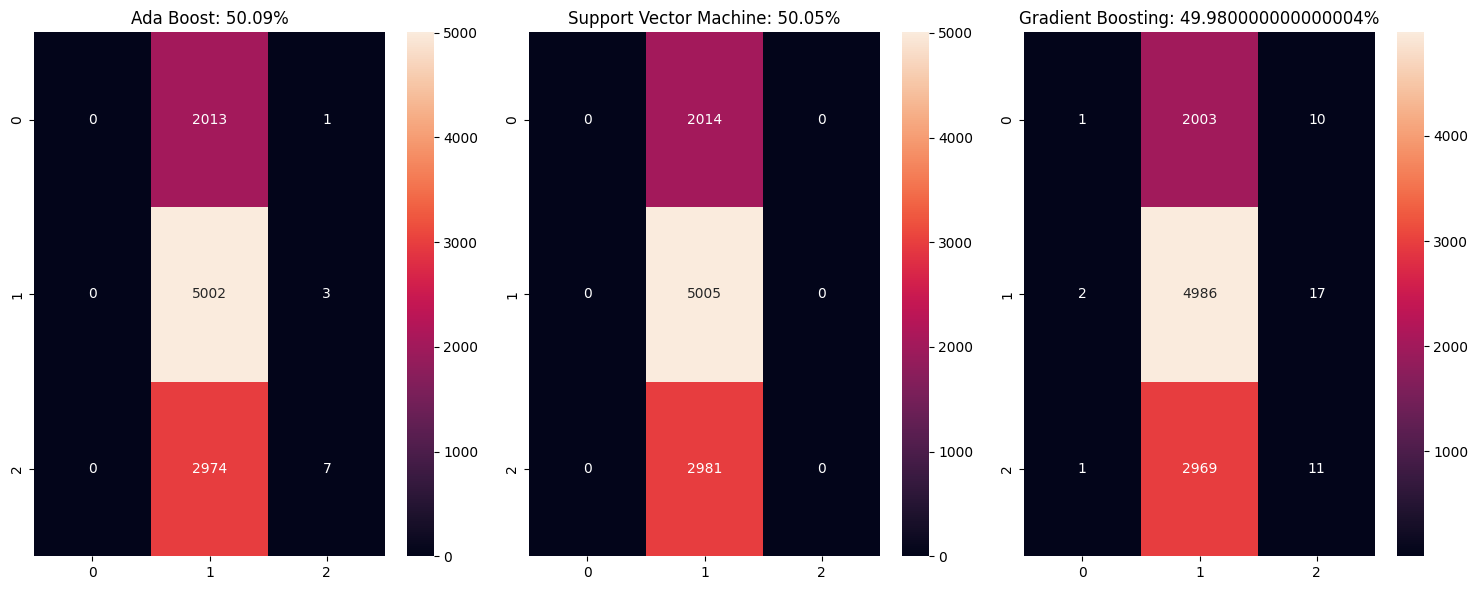

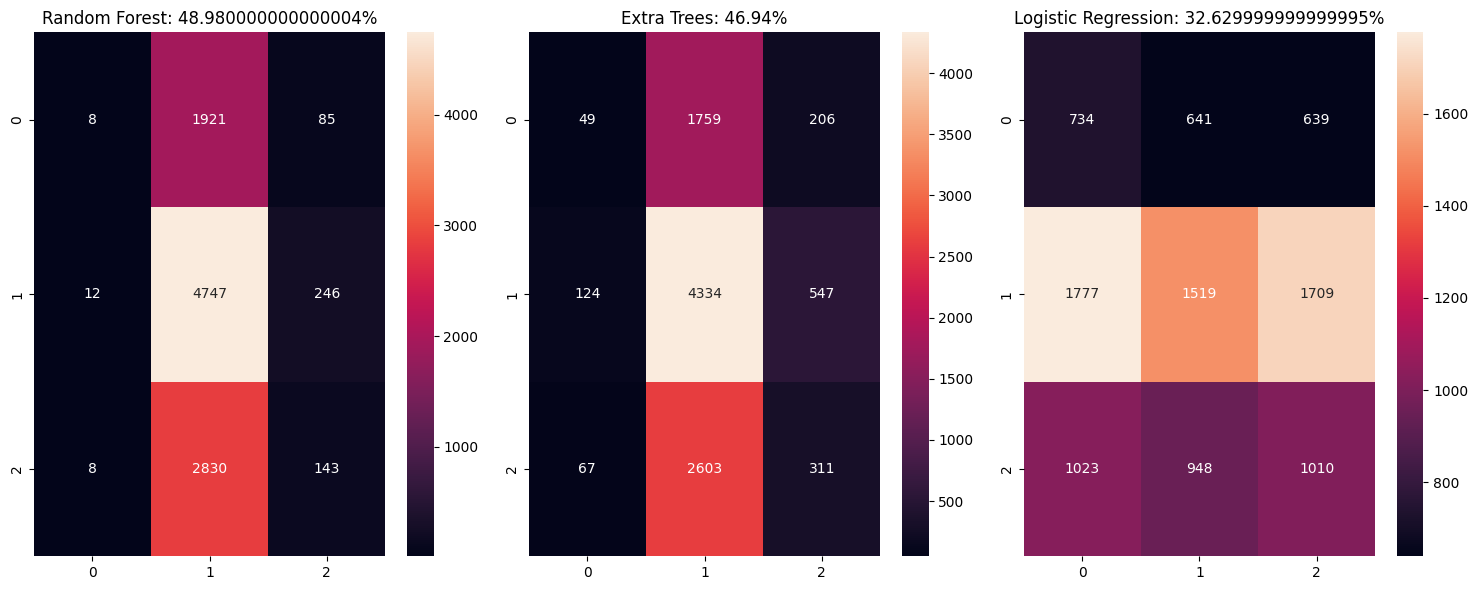

16/02/2025 11:34:13 : Info : 

16/02/2025 11:34:13 : Info : Resultaten voor model zonder hyperparameter tuning
16/02/2025 11:34:13 : Info : **********************************************
16/02/2025 11:34:13 : Info : voor models : dict_keys(['Random Forest', 'Ada Boost', 'Gradient Boosting', 'Extra Trees', 'Logistic Regression', 'Support Vector Machine'])

16/02/2025 11:34:13 : Info : 

16/02/2025 11:34:13 : Info : Resultaten voor model Random Forest
16/02/2025 11:34:13 : Info : **********************************************
16/02/2025 11:34:13 : Info : Score: [48.980000000000004]
16/02/2025 11:34:13 : Info : Classification report:               precision    recall  f1-score   support

        High       0.29      0.00      0.01      2014
         Low       0.50      0.95      0.65      5005
    Moderate       0.30      0.05      0.08      2981

    accuracy                           0.49     10000
   macro avg       0.36      0.33      0.25     10000
weighted avg       0.40      0.49  

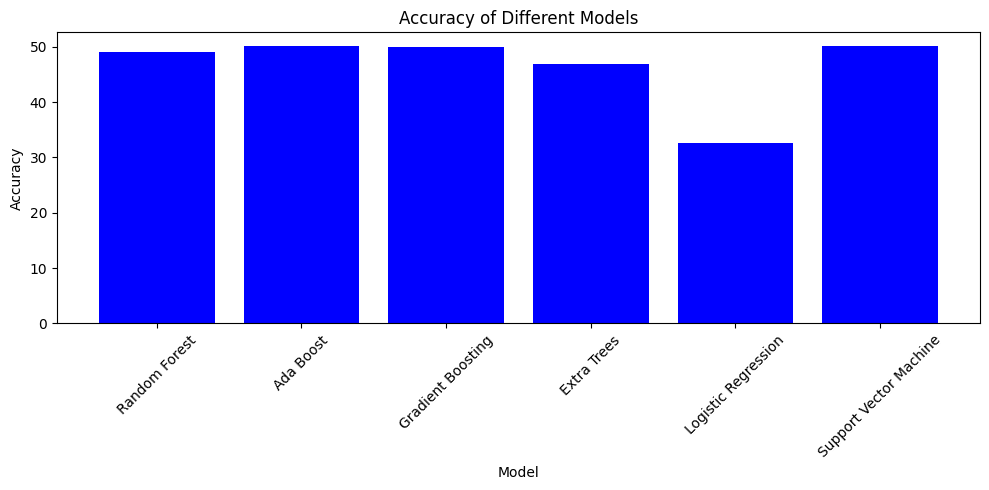

In [19]:
df = df_raw.copy()

# Separate features (X) and target variable (y)
X = df.drop(columns=['Heart_Attack_Risk'])
y = df['Heart_Attack_Risk']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scores_dict, reports_dict, cms_dict = training_classification(X_train, X_test, y_train, y_test, preprocessor)

#results_string = tabulate(results, headers='keys', tablefmt='psql')

log_info("\n")
log_info(f"Resultaten voor model zonder hyperparameter tuning")
log_info("**********************************************")
log_info(f"voor models : {scores_dict.keys()}\n")

for models in scores_dict.keys():
    log_info("\n")
    log_info(f"Resultaten voor model {models}")
    log_info("**********************************************")
    log_info(f"Score: {scores_dict[models]}")
    log_info(f"Classification report: {reports_dict[models]}")
    log_info(f"Confusion matrix: {cms_dict[models]}")
    log_info("\n\n")

# plot de scores in dict in een bar plot ten opzichte van de modellen
# Plot the scores in a bar plot
model_names = list(scores_dict.keys())
accuracies = [scores_dict[model][0] for model in model_names]

plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
save_fig("Vergelijking van modellen voor classificatie zonder Hyperparameter tuning")
plt.show()


En nu gaan we de hyperparameters van de diverse modellen tunen  met GridSearchCV

In [20]:
def execute_classification_models_with_pipeline_hyperparameter_tuning(X_train, X_test, y_train, y_test, preprocessor):
    # Hyperparameters sets voor verschillende modellen

    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    param_grid = {
        'Logistic Regression': {
            'classifier__C': [0.01, 0.1, 1.0],  # Regularisatieparameter
            'classifier__solver': ['liblinear', 'lbfgs']  # Solvers die verschillende penalties ondersteunen
        },
        'Gradient Boosting': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.1, 0.05, 0.01]
        },
        'Decision Tree': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    }
    
    results = {}
    for model_name, model in models.items():
        log_info(f"Executing execute_classification_models_with_pipeline_hyperparameter_tuning for model: {model_name}")
        pipeline = Pipeline([
            ('preprocessor', preprocessor),           
            ('classifier', model)
        ])     

        grid_search = GridSearchCV(pipeline, param_grid[model_name], scoring="f1_weighted", cv=5, refit='f1')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        results[model_name] = grid_search.best_estimator_
        best_score = grid_search.best_score_

        test_score = best_model.score(X_test, y_test)
        #print("Score op de testset:", test_score)

        y_pred = best_model.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)   
        #print(test_score)
        #print(conf_matrix)
        #print(class_report)
        results[model_name] = {'test_score': test_score, 'conf_matrix': conf_matrix, 'class_report': class_report}        
    return results

16/02/2025 11:34:13 : Info : Executing execute_classification_models_with_pipeline_hyperparameter_tuning for model: Logistic Regression


c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\data\repos\data_science_cases\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

16/02/2025 11:34:18 : Info : Executing execute_classification_models_with_pipeline_hyperparameter_tuning for model: Decision Tree
16/02/2025 11:36:08 : Info : Executing execute_classification_models_with_pipeline_hyperparameter_tuning for model: Gradient Boosting
16/02/2025 11:43:53 : Info : 

16/02/2025 11:43:53 : Info : Resultaten voor model met hyperparameter tuning
16/02/2025 11:43:53 : Info : **********************************************
16/02/2025 11:43:53 : Info : voor models : dict_keys(['Logistic Regression', 'Decision Tree', 'Gradient Boosting'])

16/02/2025 11:43:53 : Info : Resultaat voor model Logistic Regression
16/02/2025 11:43:53 : Info : Parameter: test_score
16/02/2025 11:43:53 : Info : 0.5085
16/02/2025 11:43:53 : Info : Parameter: conf_matrix
16/02/2025 11:43:53 : Info : [[   0 1987    0]
 [   0 5083    0]
 [   0 2928    2]]
16/02/2025 11:43:53 : Info : Parameter: class_report
16/02/2025 11:43:53 : Info :               precision    recall  f1-score   support

     

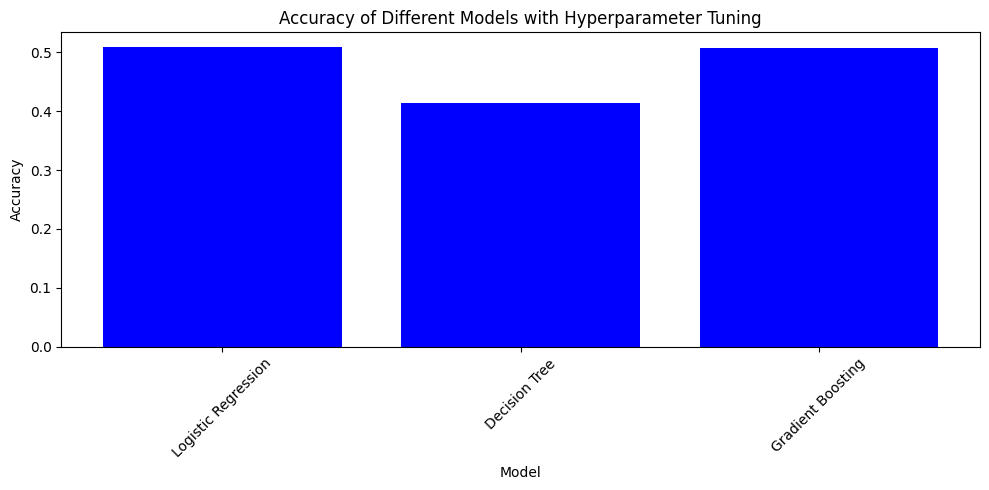

In [21]:
# we gaan eerst terug de pipelin opzetten
# deze kan aangepast worden als we andere features willen gebruiken
df = df_raw.copy() 
X = df.drop('Heart_Attack_Risk', axis=1)
y = df['Heart_Attack_Risk']

df_col = X.columns  
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = list(set(df_col) - set(df_num_col))

num_pipeline = Pipeline([   
    ("standardize_numerical", MinMaxScaler(feature_range=(-1, 1)))
    # ("standardize_numerical", StandardScaler())
])

cat_pipeline = Pipeline(steps=[   
    ('encode_categorical', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ("numerical", num_pipeline, df_num_col),
    ("categorical", cat_pipeline, df_cat_col)],
     remainder='passthrough')

# Create the pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),       
    ('regressor', LogisticRegression(class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
results = execute_classification_models_with_pipeline_hyperparameter_tuning(X_train, X_test, y_train, y_test, preprocessor)

df_results = pd.DataFrame(results, columns=['model', 'accuracy', 'report', 'cms'])
resultaat_string = tabulate(df_results, headers='keys', tablefmt='psql')

log_info("\n")
log_info(f"Resultaten voor model met hyperparameter tuning")
log_info("**********************************************")
log_info(f"voor models : {results.keys()}\n")

for keys, items in results.items():
    log_info(f"Resultaat voor model {keys}")     
    for k, item in items.items():
        log_info(f"Parameter: {k}")     
        log_info(f"{item}")    
    log_info("\n")


# haal uit de resultsdict alle waarden van de accuracy en plot deze per model
# en maak een confusion matrix voor elk model
model_names = list(results.keys())
accuracies = [results[model]['test_score'] for model in model_names]

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models with Hyperparameter Tuning')
plt.xticks(rotation=45)
save_fig("Model_accuracies_with_hyperparameter_tuning")
plt.show()

